In [1]:
import numpy as np
import tkinter as tk
import matplotlib.pyplot as plt

from PIL import Image, ImageDraw, ImageOps
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

In [2]:
from model.neural_network import NeuralNetwork
from model.layers.dense import DenseLayer
from model.layers.dropout import DropoutLayer
from model.optimizers.adam import Adam

# MNIST Dataset

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

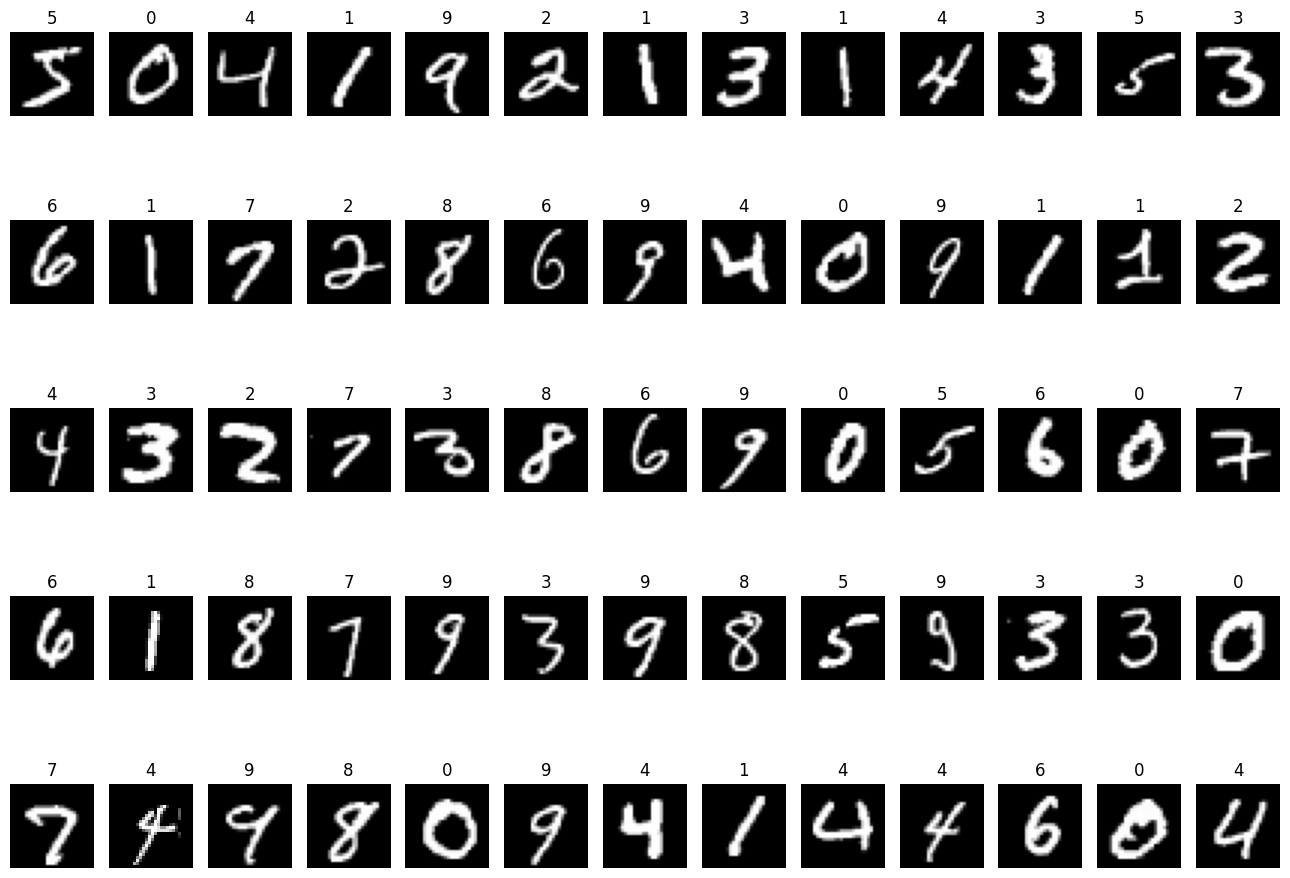

In [4]:
num_rows = 5
images_per_row = 13

plt.figure(figsize=(13, 2 * num_rows))
for row in range(num_rows):
    for i in range(images_per_row):
        index = row * images_per_row + i
        plt.subplot(num_rows, images_per_row, row * images_per_row + i + 1)
        plt.imshow(x_train[index], cmap="gray")
        plt.title(str(y_train[index]))
        plt.axis("off")

plt.tight_layout()
plt.show()

# Traning

In [4]:
x_train = x_train.reshape(-1, 28*28).astype(np.float32) / 255.0
x_test = x_test.reshape(-1, 28*28).astype(np.float32) / 255.0

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

model = NeuralNetwork([
    DenseLayer(784, 128, activation='Relu', weight_regularizer_l2=5e-4, bias_regularizer_l2=5e-4),
    DropoutLayer(rate=0.1),
    DenseLayer(128, 64, activation='Relu'),
    DropoutLayer(rate=0.1),
    DenseLayer(64, 10, activation='Softmax')
])

model.set(
    loss='CategoricalCrossentropy',
    optimizer=Adam(learning_rate=0.001, decay=1e-5)
)

model.train(x_train, y_train, epochs=100, print_every=1)

predictions = model.forward(x_test)
accuracy = np.mean(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1))
print(f"Test Accuracy: {accuracy:.4f}")

epoch: 0, loss: 2.308, lr: 0.0010000000
epoch: 1, loss: 2.306, lr: 0.0010000000
epoch: 2, loss: 2.305, lr: 0.0009999900
epoch: 3, loss: 2.303, lr: 0.0009999800
epoch: 4, loss: 2.300, lr: 0.0009999700
epoch: 5, loss: 2.296, lr: 0.0009999600
epoch: 6, loss: 2.291, lr: 0.0009999500
epoch: 7, loss: 2.284, lr: 0.0009999400
epoch: 8, loss: 2.276, lr: 0.0009999300
epoch: 9, loss: 2.265, lr: 0.0009999200
epoch: 10, loss: 2.251, lr: 0.0009999100
epoch: 11, loss: 2.235, lr: 0.0009999000
epoch: 12, loss: 2.216, lr: 0.0009998900
epoch: 13, loss: 2.192, lr: 0.0009998800
epoch: 14, loss: 2.165, lr: 0.0009998700
epoch: 15, loss: 2.134, lr: 0.0009998600
epoch: 16, loss: 2.100, lr: 0.0009998500
epoch: 17, loss: 2.061, lr: 0.0009998400
epoch: 18, loss: 2.019, lr: 0.0009998300
epoch: 19, loss: 1.974, lr: 0.0009998200
epoch: 20, loss: 1.926, lr: 0.0009998100
epoch: 21, loss: 1.876, lr: 0.0009998000
epoch: 22, loss: 1.826, lr: 0.0009997900
epoch: 23, loss: 1.775, lr: 0.0009997800
epoch: 24, loss: 1.725, lr

# Testing

In [5]:
class DigitRecognizer:
    def __init__(self, model):
        self.model = model
        self.window = tk.Tk()
        self.window.title("Draw a Digit")

        self.canvas = tk.Canvas(self.window, width=280, height=280, bg="black")
        self.canvas.pack()

        self.button_frame = tk.Frame(self.window)
        self.button_frame.pack()

        self.predict_button = tk.Button(self.button_frame, text="Predict", command=self.predict_digit)
        self.predict_button.pack(side="left")

        self.clear_button = tk.Button(self.button_frame, text="Clear", command=self.clear_canvas)
        self.clear_button.pack(side="right")

        self.canvas.bind("<B1-Motion>", self.draw)

        self.image = Image.new("L", (280, 280), color=0)  # Black background
        self.draw_image = ImageDraw.Draw(self.image)

        self.window.mainloop()

    def draw(self, event):
        x, y = event.x, event.y
        r = 8
        self.canvas.create_oval(x - r, y - r, x + r, y + r, fill="white", outline="white")
        self.draw_image.ellipse([x - r, y - r, x + r, y + r], fill=255)

    def clear_canvas(self):
        self.canvas.delete("all")
        self.draw_image.rectangle([0, 0, 280, 280], fill=0)  # Reset to black

    def predict_digit(self):
        resized = self.image.resize((28, 28))
        data = np.asarray(resized).astype(np.float32) / 255.0
        data = data.reshape(1, -1)

        prediction = self.model.forward(data)
        predicted_class = np.argmax(prediction)
        print(f"Predicted digit: {predicted_class}")

        self.window.title(f"Predicted digit: {predicted_class}")

In [8]:
DigitRecognizer(model)

Predicted digit: 1
Predicted digit: 2
Predicted digit: 3
Predicted digit: 9
Predicted digit: 5
Predicted digit: 6
Predicted digit: 3
Predicted digit: 5
Predicted digit: 8
